# Machine learning for genetic data — Part 2: Lasso 

## Reload librairies and data

Let us first reload the librairies and data used in Part 1. You can run this entire section (until the "Lasso" section) "blindly".

In [1]:
# make sure graphics are displayed inline (rather than opened in new windows)
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

In [3]:
import statsmodels.api as sm

In [4]:
from sklearn import decomposition, linear_model, metrics, model_selection

In [5]:
plt.rc('font', **{'size': 14}) # font size for text on plots

### Load data

In [6]:
# Load the genotype data
genotype_df = pd.read_csv("data/athaliana_small.genotype.txt")
genotype_df = genotype_df.set_index("Sample")

In [7]:
# Load the 2W phenotype
phenotype_df = pd.read_csv('data/athaliana_small.2W.pheno', delim_whitespace=True)

In [8]:
# Create the corresponding response vector
y_2W = np.array(phenotype_df["2W"])

In [9]:
# Create the corresponding data matrix
X_2W = np.array(genotype_df.loc[phenotype_df["IID"]])

In [10]:
num_snps = X_2W.shape[1]

In [11]:
# Load the list of candidate genes
with open('data/candidate_genes.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

In [12]:
# Load the SNP to gene mapping
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

### Correct the phenotype for population structure

In [13]:
pca = decomposition.PCA(n_components=5)
pca.fit(X_2W)
principal_components = X_2W.dot(pca.components_.T) 

# Fit a linear model between the phenotype and the principal components
model = linear_model.LinearRegression()
model.fit(principal_components, y_2W)

# Compute the model's residuals
y_pred = model.predict(principal_components)
y_2W_corrected = y_2W - y_pred

### Split the data in train/test

In [14]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W_corrected, test_size=0.2, random_state=42)
print(f"Training set shape: {X_2W_tr.shape}\nTest set shape: {X_2W_te.shape}")

Training set shape: (121, 9419)
Test set shape: (31, 9419)


## Lasso

We will now learn another linear model on the data, using all SNPs, but instead of using a simple ordinary least squares approach, we will use a Lasso. The l1 regularisation term will help us learn a sparse model.

### Scaling the phenotype

Although it does not matter for the ordinary least squares, _regularized_ linear regression work better if the inputs are all on the same scale (which is the case here) and if the outputs are centered on 0 with a standard deviation of 1.

We therefore transform the outputs accordingly.

Note that we compute the mean and standard deviation _on the train set_ because we are pretending at this stage not to know the test set.

In [15]:
from sklearn import preprocessing

In [16]:
scaler = preprocessing.StandardScaler()
scaler.fit(y_2W_tr.reshape(-1, 1))
y_2W_tr_scaled = scaler.transform(y_2W_tr.reshape(-1, 1)).reshape(-1, )

Text(0, 0.5, 'Number of samples')

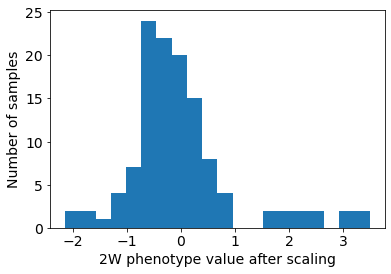

In [17]:
h = plt.hist(y_2W_tr_scaled, bins=20)
plt.xlabel("2W phenotype value after scaling")
plt.ylabel("Number of samples")

__Q: What was the effect of StandardScaler()?__

**Answer:**

### Regularization path

To better understand what the lasso does and what is the role of the regularization parameter `alpha`, we will first use the `lasso_path` method to compute the _regularization path_ of the Lasso: we obtain the regression coefficient of each feature/SNP in a model learned with a lasso _for a range of values of `alpha`_.

In [18]:
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X_2W_tr, y_2W_tr_scaled)

We can now plot, for each SNP, how its coefficient in the linear model learned by the lasso evolves with `alpha`. Let us start with the SNP at index 100:

Text(0.5, 1.0, 'Regularization path for SNP Chr1_3089429_C')

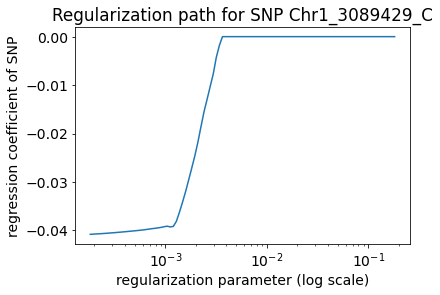

In [19]:
plt.plot(alphas_lasso, coefs_lasso[100, :])
plt.xscale("log")
plt.xlabel("regularization parameter (log scale)")
plt.ylabel("regression coefficient of SNP")
plt.title(f"Regularization path for SNP {genotype_df.columns[100]}")

__Q: What is the effect of the regularization parameter on the SNP's coefficient?__

__Answer:__

We can now repeat the same plot for all SNPs for which the regression coefficient takes non-zero values along the regularization path (otherwise, we'll just have a flat line on the y=0 axis).

In [20]:
non_zero_coef_ = np.where(np.max(np.abs(coefs_lasso), axis=1))[0]

Text(0.5, 1.0, 'Regularization paths for the Lasso')

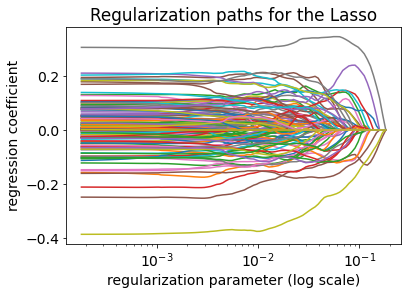

In [21]:
for feature_idx in non_zero_coef_:
    plt.plot(alphas_lasso, coefs_lasso[feature_idx, :])
plt.xscale("log")
plt.xlabel("regularization parameter (log scale)")
plt.ylabel("regression coefficient")
plt.title("Regularization paths for the Lasso")

We can now repeat the same plot for all SNPs for which the regression coefficient takes relatively large values along the regularization path:

In [22]:
non_zero_coef_ = np.where(np.max(np.abs(coefs_lasso), axis=1) > 0.15)[0]

Text(0.5, 1.0, 'Regularization paths for the Lasso')

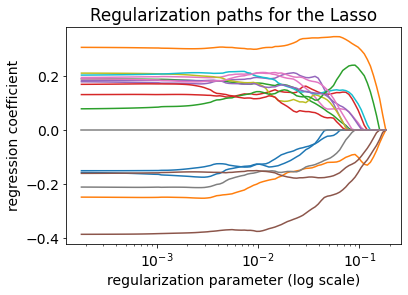

In [23]:
for feature_idx in non_zero_coef_:
    plt.plot(alphas_lasso, coefs_lasso[feature_idx, :])
plt.plot(alphas_lasso, [0 for x in alphas_lasso], 'gray') # y=0 axis
plt.xscale("log")
plt.xlabel("regularization parameter (log scale)")
plt.ylabel("regression coefficient")
plt.title("Regularization paths for the Lasso")

__Q: Is the effect of the regularization parameter the same on all SNPs?__

__Answer:__

### Grid of values for the regularization coefficient

The method [`linear_model._coordinate_descent._alpha_grid`](https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/linear_model/_coordinate_descent.py#L86), used to compute the grid of values of `alpha` along which to compute the regularization path, computes the maximum value of `alpha` (that is to say, the one that gives a solution where all regression coefficients are equal to 0). Even without computing regularization paths, we can use it to decide on the grid of values of `alpha` to use.

In [24]:
alpha_max, alpha_min = linear_model._coordinate_descent._alpha_grid(X_2W_tr, y_2W_tr_scaled, n_alphas=2)
print(f"The maximum value of alpha is {alpha_max:.3f}.")

The maximum value of alpha is 0.182.


__Comment:__ `alpha_min` is set to `alpha_max` * `eps`, where `eps` is a parameter of `_alpha_grid` with default value 1e-3.

__Q: How can you use `linear_model._coordinate_descent._alpha_grid` to obtain a grid of 10 values of `alpha`?__

**Answer:**

### Fitting a lasso

We use the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) class of the `linear_model` module of scikit-learn:

In [25]:
lasso = linear_model.Lasso(fit_intercept=True, max_iter=1000)

We can now use grid search and cross-validation to select the value of `alpha`:

In [26]:
# Grid of values for the alpha parameter
alphas = linear_model._coordinate_descent._alpha_grid(X_2W_tr, y_2W_tr_scaled, n_alphas=10)

# Set up the grid search cross validation
model_l1 = model_selection.GridSearchCV(lasso, param_grid={'alpha': alphas},
                                        cv=3, # 3-fold cross-validation
                                        verbose=3) # use verbose=3 to obtain more details 

# Use the grid search cross validation on the training data
model_l1.fit(X_2W_tr, y_2W_tr_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ........alpha=0.18183702541183483;, score=-0.055 total time=   0.0s
[CV 2/3] END ........alpha=0.18183702541183483;, score=-0.066 total time=   0.0s
[CV 3/3] END .........alpha=0.18183702541183483;, score=0.038 total time=   0.0s
[CV 1/3] END .........alpha=0.0844012706688935;, score=-0.053 total time=   0.1s
[CV 2/3] END ..........alpha=0.0844012706688935;, score=0.029 total time=   0.0s
[CV 3/3] END ..........alpha=0.0844012706688935;, score=0.032 total time=   0.1s
[CV 1/3] END ........alpha=0.03917559954794657;, score=-0.274 total time=   0.2s
[CV 2/3] END .........alpha=0.03917559954794657;, score=0.073 total time=   0.1s
[CV 3/3] END .........alpha=0.03917559954794657;, score=0.028 total time=   0.1s
[CV 1/3] END .......alpha=0.018183702541183473;, score=-0.457 total time=   0.3s
[CV 2/3] END ........alpha=0.018183702541183473;, score=0.022 total time=   0.2s
[CV 3/3] END ........alpha=0.018183702541183473;

/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e-02, tolerance: 9.061e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END ......alpha=0.0018183702541183474;, score=-0.576 total time=   0.5s
[CV 2/3] END ......alpha=0.0018183702541183474;, score=-0.004 total time=   0.5s
[CV 3/3] END .......alpha=0.0018183702541183474;, score=0.043 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-02, tolerance: 9.061e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END ......alpha=0.0008440127066889349;, score=-0.526 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-02, tolerance: 5.805e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END ......alpha=0.0008440127066889349;, score=-0.012 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e-02, tolerance: 9.197e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END .......alpha=0.0008440127066889349;, score=0.085 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e-02, tolerance: 9.061e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END ......alpha=0.0003917559954794661;, score=-0.642 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-02, tolerance: 5.805e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END .......alpha=0.0003917559954794661;, score=0.013 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.770e-02, tolerance: 9.197e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END .......alpha=0.0003917559954794661;, score=0.060 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.329e-02, tolerance: 9.061e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END .....alpha=0.00018183702541183473;, score=-0.707 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-02, tolerance: 5.805e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END ......alpha=0.00018183702541183473;, score=0.034 total time=   0.5s
[CV 3/3] END ......alpha=0.00018183702541183473;, score=0.011 total time=   0.5s


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.679e-02, tolerance: 9.197e-03
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': array([1.81837025e-01, 8.44012707e-02, 3.91755995e-02, 1.81837025e-02,
       8.44012707e-03, 3.91755995e-03, 1.81837025e-03, 8.44012707e-04,
       3.91755995e-04, 1.81837025e-04])},
             verbose=3)

__Convergence Warnings:__ In the output from the above code, you will have obtained convergence warnings. These are warning you that the optimization procedure that finds the lasso solution did not converge. This happens for small values of `alpha` (you can check this by setting `verbose=3` in the `GridSearchCV`), and indeed, the warning message suggests to increase regularization. Such warnings are bound to happen in a cross-validation loop, but when the optimization do not converge, the model fit will be poor and hence the corresponding value of the regularization parameter will not be chosen. We can therefore opt to turn off these warnings with the following bit of code, to make our notebook easier to read.

Note that in general, it's probably better to have warning and worry about why you get them than to turn them off blindly!

In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

The lasso model retrained with the optimal value of `alpha` is now stored in `model_l1.best_estimator_`.

We can check what the optimal value of `alpha` was:

In [28]:
print(f"The best value of alpha is {model_l1.best_params_['alpha']:.3f}")

The best value of alpha is 0.084


__Q: How close is this value of `alpha` to the lower/upper values of your range? Do you expect a sparse solution?__

**Answer:**

### Selected SNPs

Let us now plot the regression weights of this new model:

Text(0.5, 1.0, 'Regression coefficients of a lasso')

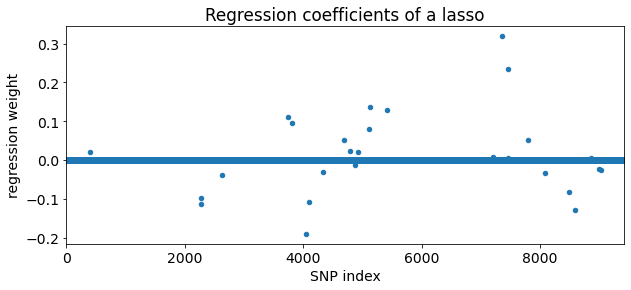

In [29]:
plt.figure(figsize = (10, 4))
plt.scatter(range(num_snps), model_l1.best_estimator_.coef_, s=20)

plt.xlabel("SNP index")
plt.ylabel("regression weight")
plt.xlim([0, num_snps])
plt.title("Regression coefficients of a lasso")

We can further highlight the non-zero coefficients in this model:

Text(0.5, 1.0, 'Regression coefficients of a lasso')

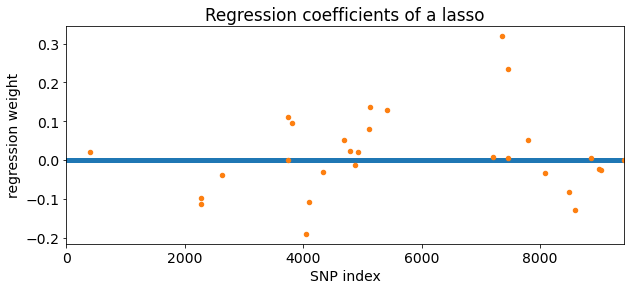

In [30]:
nonzero_weight_indices = np.where(model_l1.best_estimator_.coef_)[0]

plt.figure(figsize = (10, 4))
# plot for all SNPs
plt.scatter(range(num_snps), model_l1.best_estimator_.coef_, s=10) 
# plot for SNPs with nonzero coefficients
plt.scatter(nonzero_weight_indices, model_l1.best_estimator_.coef_[nonzero_weight_indices], s=20) 


plt.xlabel("SNP index")
plt.ylabel("regression weight")
plt.xlim([0, num_snps])
plt.title("Regression coefficients of a lasso")

__Q: How many SNPs contribute to explaining the phenotype? Does this match your expectations?__

**Answer:**

Let us now see how many of these SNPs point to genes in the list of candidate genes:

In [31]:
selected_candidate_genes = []
num_snps_pointing_to_candidates = 0
for snp_name in genotype_df.columns[nonzero_weight_indices]:
    matching_genes = genes_by_snp[snp_name]
    candidate_matching_genes = set(matching_genes).intersection(set(candidate_genes))
    if len(candidate_matching_genes):
        num_snps_pointing_to_candidates += 1
        selected_candidate_genes.extend(candidate_matching_genes)
print(f"{num_snps_pointing_to_candidates} of the {len(nonzero_weight_indices)} selected SNP(s) point to {len(selected_candidate_genes)} candidate genes.")

29 of the 29 selected SNP(s) point to 30 candidate genes.


In [32]:
print(selected_candidate_genes)

['AT1G14920', 'AT1G79730', 'AT1G79730', 'AT2G18915', 'AT3G02380', 'AT3G02380', 'AT3G04610', 'AT3G11540', 'AT3G12810', 'AT3G19980', 'AT3G47500', 'AT3G54720', 'AT3G54990', 'AT3G57390', 'AT3G62090', 'AT3G62090', 'AT4G01060', 'AT5G03790', 'AT5G04240', 'AT5G10140', 'AT5G10140', 'AT5G15960', 'AT5G15970', 'AT5G23150', 'AT5G37770', 'AT5G39660', 'AT5G49160', 'AT5G60100', 'AT5G60100', 'AT5G67100']


### Quality of model fit

As before, we can check how well our model fits the data it was trained on.

In [33]:
y_2W_l1_pred = model_l1.best_estimator_.predict(X_2W_tr)
pve = metrics.explained_variance_score(y_2W_tr_scaled, y_2W_l1_pred) * 100
print(f"The percentage of variance explained by a lasso using all SNPs is {pve:.0f}%")

The percentage of variance explained by a lasso using all SNPs is 52%


We can also plot the predictions vs the true phenotype for all samples from the train set:

Text(0.5, 1.0, 'Goodness of fit of the lasso')

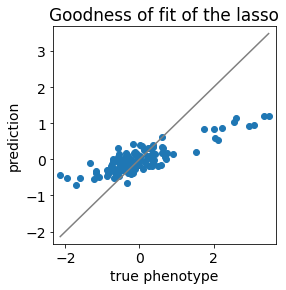

In [34]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_tr_scaled, y_2W_l1_pred)

# plot a line y=x
x_min = np.min(y_2W_tr_scaled)
x_max = np.max(y_2W_tr_scaled)
plt.plot([x_min, x_max], [x_min, x_max], c='gray')

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([x_min-0.2, x_max+0.2])
plt.ylim([x_min-0.2, x_max+0.2])

plt.title("Goodness of fit of the lasso")

__Q: How well does the model fit the training data? Compare to the linear regression. Is this surprising?__

**Answer:**

### Model predictive power 

Again, we can use the test set to evaluate the predictive power of the model, on the test set.

In [35]:
y_2W_te_scaled = scaler.transform(y_2W_te.reshape(-1, 1)).reshape(-1, )

In [36]:
y_2W_l1_pred = model_l1.best_estimator_.predict(X_2W_te)
pve = metrics.explained_variance_score(y_2W_te_scaled, y_2W_l1_pred) * 100
print(f"The percentage of variance explained by a lasso using all SNPs is {pve:.0f}%")

The percentage of variance explained by a lasso using all SNPs is 6%


And let us plot the predictions vs the true phenotype for all samples from the test set:

Text(0.5, 1.0, 'Lasso')

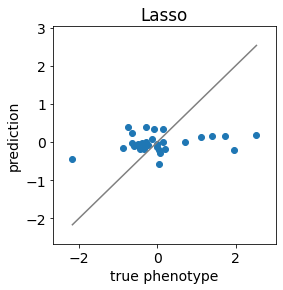

In [37]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_te_scaled, y_2W_l1_pred)

# plot a line y=x
x_min = np.min(y_2W_te_scaled)
x_max = np.max(y_2W_te_scaled)
plt.plot([x_min, x_max], [x_min, x_max], c='gray')

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([x_min - 0.5, x_max + 0.5])
plt.ylim([x_min - 0.5, x_max + 0.5])

plt.title("Lasso")

__Q: How well does the model predict on the test data? Compare to the linear regression and to the values on the train set. Is this surprising?__

**Answer:**

## Stability

An important aspect of a feature selection algorithm is its _stability_: do we select the same features using only subsets of the data? Of course reducing the number of samples reduces statistical power; but if a feature is truly important, it should be selected every time.

To evaluate stability, we can 
1. Create subsamples of our training data 
1. Run the feature selection algorithm on each of these subsamples
1. Compare the sets of selected features.

### Method to measure stability

We will need a wrapper around `scipy.stats.pearsonr` to deal with the case where vectors are constant, ie. when all features are selected (vector of all ones) or when none are selected (vector of all zeros). Indeed, Pearson's correlation is not defined for constant vectors, even when they are identical. 

We will keep returning NaN for the correlation between a constant vector and a non-constant vector. This will raise a warning and the corresponding pair of selected sets of features will not be taken into account in the overall measure of stability.

In [38]:
import scipy.stats as st

In [39]:
def pearson_corr(vector1, vector2):
    """
    Returns Pearson's correlation between two vectors of 0 and 1. 
    """
    # if the first or the second vector is constant
    if (vector1 == vector1[0]).all() and (vector2 == vector2[0]).all():
            # return 1 if both are the same and 0 otherwise
            return 1. if (vector1[0] == vector2[0]) else 0.
    return st.pearsonr(vector1, vector2)[0]

Now we can define a function that measures the stability of a selection procedure.

In [40]:
def stability(X_train, y_train, selection_procedure, num_subsamples, subsample_size):
    """
    Sample the training data (X_train, y_train) num_subsamples times.
    Apply the selection procedure on each subsample.
    Return a mesure of stability of the procedure
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    selection_procedure: function
       input parameters: (training_data, training_labels)
       outputs: (n_features, ) np.array of 0 and 1 
           1 for selected features
           0 for non-selected features
    num_subsamples: int
        number of subsamples to use
    subsample_size: int
        number of samples in the subsample   
        
    Output
    ------
    pearson_corr: float
        Pearson's measure of stability of the selection procedure
    """
    n_samples, n_features = X_train.shape
    sample_indices = np.arange(n_samples) 
    
    # check there is the same number of samples in X and y
    assert len(y_train) == n_samples
    
    # check the subsample size is less than the sample size
    assert subsample_size < n_samples
    
    # run the feature selection procedure on the subsamples
    selected_features_list = []
    for idx in range(num_subsamples):
        # shuffle the indices
        np.random.shuffle(sample_indices)
        # create the subsample indices
        ss_indices = sample_indices[:subsample_size]
        # run the feature selection procedure
        # and append the results to selected_features_list
        selected_features_list.append(selection_procedure(X_train[ss_indices, :], y_train[ss_indices]))
    
    # compute the average pairwise Pearson's correlation between the list of selected features
    all_correlations = [pearson_corr(selected_features, selected_features_2) for (idx, selected_features) in enumerate(selected_features_list) \
                        for selected_features_2 in selected_features_list[idx+1:]]
    
    return np.nanmean(all_correlations)

### Stability of the t-test
To use the `stability` function we have just defined, we need to wrap what we did in the T-test section into a function that can be passed as the `selection_procedure` argument. This function should take a data set as input and return the binary vector represented the selected features as output.

In [41]:
def t_test_selection_procedure(X_train, y_train):
    """
    Run t-test of association between each feature and the outcome. 
    Selects the features with p-values < 0.05/num_features
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected
            selection[j] = 1 otherwise.       
    """
    n_samples, n_features = X_train.shape
    # check there is the same number of samples in X and y
    assert len(y_train) == n_samples    
    
    pvalues = []
    for feat_idx in range(n_features):
        # only look at the column corresponding to that feature
        x = X_train[:, feat_idx]
        # run a linear regression (with bias) between the phenotype and this SNP
        x = sm.add_constant(x)
        est = sm.regression.linear_model.OLS(y_train, x)
        est = est.fit()
    
        # get the p-value from the model 
        pvalues.append(est.pvalues[1])

    # convert the list of p-values to a numpy array
    pvalues = np.array(pvalues)
    
    # threshold the p-values
    thr = 0.05/n_features
    selection = np.where(pvalues < thr, 1, 0)    
    print(f"Significant SNPs: {*genotype_df.columns[np.where(selection)[0]],}")
    return selection

As a sanity check, we can apply that method to the full data set and check we obtain the same results as earlier:

In [42]:
t_test_sel = t_test_selection_procedure(X_2W, y_2W_corrected)

Significant SNPs: ('Chr3_23008395_C',)


Let us now use `stability` to measure the stability of this procedure:

In [43]:
# use 90% of the data size as subsample size
subsize = int(round(0.9*len(y_2W_corrected)))
t_test_stab = stability(X_2W, y_2W_corrected, t_test_selection_procedure, 10, subsize)

Significant SNPs: ('Chr3_23008395_C', 'Chr5_3171095_A', 'Chr5_3172628_T', 'Chr5_3184569_T')
Significant SNPs: ()
Significant SNPs: ()
Significant SNPs: ('Chr3_23008395_C',)
Significant SNPs: ('Chr5_5812297_A',)
Significant SNPs: ('Chr5_5812297_A',)
Significant SNPs: ('Chr3_23008395_C',)
Significant SNPs: ()
Significant SNPs: ('Chr3_23008395_C', 'Chr5_5812297_A')
Significant SNPs: ('Chr3_23008395_C',)


/home/cazencott/local/miniconda3/envs/mlgen/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


__Q: At each iteration, we have printed the selected SNPs. What do you observe?__

**Answer:**

In [44]:
print(f"The stability of the T-test selection is: {t_test_stab:.3f}")

The stability of the T-test selection is: 0.516


__Q: Does this numerical measure of stability match your observations?__

**Answer:**

### Stability of the Lasso
Let us wrap what we did in the Lasso section into a method which takes a data set as input and selects the features significantly associated with the output.

In [45]:
def lasso_selection_procedure(X_train, y_train):
    """
    Fits a lasso on the data. Returns the features with non-zero coefficients.
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected
            selection[j] = 1 otherwise.       
    """
    # create a lasso object
    lasso = linear_model.Lasso(fit_intercept=True, max_iter=1000)
    
    # Grid of values for the alpha parameter
    alphas = linear_model._coordinate_descent._alpha_grid(X_train, y_train, n_alphas=10, eps=1e-2)

    # Set up the grid search cross validation
    model_l1 = model_selection.GridSearchCV(lasso, param_grid={'alpha': alphas}, 
                                            cv=3)

    # Use the grid search cross validation on the training data
    model_l1.fit(X_train, y_train)
    
    print(f"Optimal alpha: {model_l1.best_estimator_.alpha:.3f}\t" \
          f"Selected SNPs: {*genotype_df.columns[np.where(model_l1.best_estimator_.coef_)[0]],}")    
    
    # Consider the non-zero coefficients as selected
    return(np.where(model_l1.best_estimator_.coef_, 1, 0))

In [46]:
# use 90% of the data size as subsample size
subsize = int(round(0.9*len(y_2W_tr)))

# compute stability
lasso_stab = stability(X_2W_tr, y_2W_tr_scaled, lasso_selection_procedure, 10, subsize)

Optimal alpha: 0.002	Selected SNPs: ('Chr1_1196290_A', 'Chr1_4275011_T', 'Chr1_4308649_A', 'Chr1_4309713_G', 'Chr1_5356387_G', 'Chr1_6350963_G', 'Chr1_9615772_T', 'Chr1_11039416_A', 'Chr1_16474533_A', 'Chr1_17839049_T', 'Chr1_17843006_A', 'Chr1_17843037_A', 'Chr1_17843128_T', 'Chr1_17843881_T', 'Chr1_18325367_A', 'Chr1_22485802_G', 'Chr1_22489271_T', 'Chr1_23256450_C', 'Chr1_23266100_C', 'Chr1_23267179_A', 'Chr1_24320333_A', 'Chr1_24729610_G', 'Chr1_26432862_T', 'Chr1_26937005_T', 'Chr1_29041439_C', 'Chr1_29044150_C', 'Chr1_29045537_A', 'Chr1_29045883_A', 'Chr1_29842223_A', 'Chr1_29911157_A', 'Chr1_30020796_A', 'Chr1_30021468_T', 'Chr1_30334006_A', 'Chr2_8123308_C', 'Chr2_8127891_A', 'Chr2_8448098_C', 'Chr2_8450682_C', 'Chr2_8460494_C', 'Chr2_8478404_G', 'Chr2_9021852_G', 'Chr2_9581605_C', 'Chr2_10571603_C', 'Chr2_11041934_A', 'Chr2_11044367_G', 'Chr2_16370409_C', 'Chr2_19003518_A', 'Chr2_19019256_T', 'Chr3_505329_A', 'Chr3_507969_G', 'Chr3_1256038_T', 'Chr3_1257380_C', 'Chr3_1427788_A

In [47]:
print(f"The stability of the Lasso selection is: {lasso_stab:.3f}")

The stability of the Lasso selection is: 0.342


__Q: Compare this stability to that of the t-test. Does it match your expectations based on the sets of selected SNPs at each iteration?__

**Answer:**

### Stability of the Lasso with a fixed amount of regularization

One of the reasons for the instability of the Lasso selection procedure is the fact that solutions with a different value of `alpha` are selected for each repeat. An alternative option is to use a _fixed_ amount of regularization:

In [48]:
def fixed_alpha_lasso_selection_procedure(X_train, y_train):
    """
    Fits a lasso on the data. Returns the features with non-zero coefficients.
    
    Rather than cross-validating alpha, use a fixed amount of regularization 
    (alpha=0.1).
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected
            selection[j] = 1 otherwise.       
    """
    # create a lasso object
    lasso = linear_model.Lasso(fit_intercept=True, max_iter=1000, alpha=0.1)

    # Use the grid search cross validation on the training data
    lasso.fit(X_train, y_train)
    
    print(f"Selected SNPs: {*genotype_df.columns[np.where(lasso.coef_)[0]],}")    
    
    # Consider the non-zero coefficients as selected
    return(np.where(lasso.coef_, 1, 0))

In [49]:
# use 90% of the data size as subsample size
subsize = int(round(0.9*len(y_2W_tr)))

# compute stability
lasso_stab = stability(X_2W_tr, y_2W_tr_scaled, fixed_alpha_lasso_selection_procedure, 10, subsize)

Selected SNPs: ('Chr1_17843006_A', 'Chr1_25973043_G', 'Chr1_30021468_T', 'Chr2_8177342_C', 'Chr2_18425301_A', 'Chr2_19019256_T', 'Chr3_1256038_T', 'Chr3_1257380_C', 'Chr3_3652430_A', 'Chr3_6983030_C', 'Chr3_17512067_T', 'Chr3_20390008_G', 'Chr3_22984636_T', 'Chr3_23008395_C', 'Chr4_454542_A', 'Chr4_460246_T', 'Chr4_475593_A', 'Chr5_1168046_T', 'Chr5_14996667_G', 'Chr5_15863849_T', 'Chr5_19953902_A', 'Chr5_24190884_T', 'Chr5_26789458_A')
Selected SNPs: ('Chr1_9615772_T', 'Chr1_30020796_A', 'Chr1_30021468_T', 'Chr3_505329_A', 'Chr3_507969_G', 'Chr3_3652430_A', 'Chr3_4073911_C', 'Chr3_6983030_C', 'Chr3_20236730_T', 'Chr3_22984636_T', 'Chr3_23008395_C', 'Chr4_1071480_G', 'Chr5_987682_T', 'Chr5_1168046_T', 'Chr5_3172628_T', 'Chr5_5207068_T', 'Chr5_14995268_A', 'Chr5_14996667_G', 'Chr5_15863849_T')
Selected SNPs: ('Chr1_24729610_G', 'Chr1_30020796_A', 'Chr1_30021468_T', 'Chr1_30022260_T', 'Chr1_30347069_A', 'Chr2_8443805_T', 'Chr2_8446992_T', 'Chr2_8478404_G', 'Chr2_11041934_A', 'Chr2_184253

In [50]:
print(f"The stability of the Lasso selection is now: {lasso_stab:.3f}")

The stability of the Lasso selection is now: 0.465


__Q: Compare this stability to that of the lasso with cross-validation of the parameters. Does it match your expectations?__

**Answer:**

## Further practice: Stability selection

One idea that was put forward to increase the stability of the Lasso is _stability selection_. The basic idea is to repeatedly subsample the data and perform the selection procedure, as we just did to _measure_ stability, and then to consider as selected only the features that appear are selected in a large proportion of the repeats. 

__Q: Implement this idea on the Lasso. Measure the stability of your new selection procedure. Discuss.__